In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Fiscal Risk in Europe: Clustering, Resilience, and Forecasting

**Goal:** Build an interpretable fiscal risk framework for European countries using [Eurostat](https://ec.europa.eu/eurostat/databrowser/product/page/GOV_10DD_EDPT1) government finance data.

**Outputs:**
- Clean panel dataset with **Debt-to-GDP**, **Deficit-to-GDP**, **Debt Growth**
- Country clusters (Stable / Moderate Risk / High Risk)
- Fiscal shock resilience index (GFC + COVID)
- Composite fiscal risk score + Europe choropleth + bubble chart
- Simple time-series forecasts (ARIMA, VAR) for a selected country


## 1) Setup

In [88]:

# Core
import pandas as pd
import numpy as np

# Modeling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

# Time series
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import VAR

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px

# Display helpers (works in Colab; falls back gracefully elsewhere)
try:
    from google.colab import data_table
    data_table.enable_dataframe_formatter()
    IN_COLAB = True
except Exception:
    IN_COLAB = False

# Paths (Colab usually uses /content; this project uses uploaded files under /mnt/data)
TSV_PATH = "/mnt/data/estat_gov_10dd_edpt1.tsv"  # uploaded with the notebook
CHOROPLETH_CSV = "/mnt/data/choropleth_data.csv" # optional (if you already exported it)


## 2) Load Eurostat TSV (quick inspection)

In [89]:

df_raw = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/docx fiscal/estat_gov_10dd_edpt1.tsv", sep="\t")
print("Shape:", df_raw.shape)
print("First columns:", list(df_raw.columns[:5]))
display(df_raw.head(5))


Shape: (2103, 31)
First columns: ['freq,unit,sector,na_item,geo\\TIME_PERIOD', '1995 ', '1996 ', '1997 ', '1998 ']


,"freq,unit,sector,na_item,geo\TIME_PERIOD",1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,"A,MIO_EUR,S1,B1GQ,AT",183629.2,185944.9,186913.0,193947.1,203064.9,212406.8,219373.3,225087.9,230541.9,...,342083.5,355665.6,367294.9,383234.3,395706.8,380317.9,406231.5,449382.2,477837.3,494087.6
1,"A,MIO_EUR,S1,B1GQ,BE",220251.5,219965.3,223032.7,231015.7,242307.6,256376.4,264334.9,273255.9,281200.2,...,415538.0,428467.1,443407.2,459491.8,479444.9,463750.9,506047.2,561309.1,602376.3,620271.8
2,"A,MIO_EUR,S1,B1GQ,BG",14512.8,9829.8,10064.7,13437.6,12804.4,14440.0,15905.3,17478.3,18798.3,...,45797.8,48752.1,52501.8,56000.6,61195.4,61856.5,71345.0,86079.5,94526.6,104768.8
3,"A,MIO_EUR,S1,B1GQ,CY",7596.0,7890.1,8414.3,9152.6,9839.7,10804.6,11602.9,12083.0,12871.3,...,17944.2,19013.8,20312.4,21807.8,23400.9,22373.6,25679.9,29645.4,32439.2,34770.2
4,"A,MIO_EUR,S1,B1GQ,CZ",46333.6,53416.0,55174.6,60164.9,61470.4,67409.2,76070.6,87795.9,88965.6,...,170527.3,179145.9,196738.7,213505.4,229406.7,220310.6,246012.3,286976.8,319099.1,320741.7


If you're in **Google Colab**, the table below is interactive (sort/filter).

In [90]:

if IN_COLAB:
    data_table.DataTable(df_raw.head(30))
else:
    display(df_raw.head(30))


## 3) Tidy the dataset into a panel

Eurostat stores multiple dimensions in the first column. We'll split those dimensions, keep the **government sector**, and reshape years into rows.


In [91]:

def tidy_eurostat_gov_tsv(df: pd.DataFrame) -> pd.DataFrame:
    first_col = df.columns[0]

    # Split dimensions from the first column
    dims = df[first_col].str.split(",", expand=True)
    dims.columns = ["freq", "unit", "sector", "na_item", "geo"]

    out = df.drop(columns=[first_col]).copy()
    out = pd.concat([dims, out], axis=1)

    # Clean 'geo' (removes \TIME_PERIOD suffix if present)
    out["geo"] = out["geo"].str.replace(r"\\TIME_PERIOD", "", regex=True)

    # Remove EU aggregates (keep only countries)
    out = out[~out["geo"].isin(["EA", "EU27_2020_AVG"])].copy()

    # Year columns are numeric strings
    year_cols = [c for c in out.columns if str(c).strip().isdigit()]

    long = out.melt(
        id_vars=["na_item", "geo"],
        value_vars=year_cols,
        var_name="year",
        value_name="value"
    )

    long["year"] = long["year"].astype(int)

    # Clean values: ":" means missing; sometimes there are flags (e.g., "123.4 e")
    long["value"] = (
        long["value"]
        .astype(str)
        .str.strip()
        .replace({":": np.nan, "": np.nan})
        .str.replace(r"[^0-9\.\-]", "", regex=True)
    )
    long["value"] = pd.to_numeric(long["value"], errors="coerce")

    long = long.dropna(subset=["value"]).rename(columns={"geo": "country"})
    return long

df_long = tidy_eurostat_gov_tsv(df_raw)
print("Long format shape:", df_long.shape)
display(df_long.head())
print("na_item values:", sorted(df_long["na_item"].unique())[:10], "...")


Long format shape: (51636, 4)


,na_item,country,year,value
0,B1GQ,AT,1995,183629.2
1,B1GQ,BE,1995,220251.5
2,B1GQ,BG,1995,14512.8
3,B1GQ,CY,1995,7596.0
4,B1GQ,CZ,1995,46333.6


na_item values: ['AF_81L', 'B1GQ', 'B5GQ', 'B9', 'D41PAY', 'GD', 'GD_F2', 'GD_F3', 'GD_F31', 'GD_F32'] ...


## 4) Build core fiscal metrics

We extract:
- **GDP** (`B1GQ`)
- **Government debt** (`GD`)
- **Net lending/borrowing** (`B9`) → treated as *deficit* (negative values are deficits)


In [92]:

# Pivot to wide form: one row per (country, year)
wide = df_long.pivot_table(index=["year", "country"], columns="na_item", values="value", aggfunc="first")

needed = ["B1GQ", "GD", "B9"]
wide = wide[needed].dropna().reset_index().rename(columns={"B1GQ":"GDP", "GD":"Debt", "B9":"Deficit"})

# Feature engineering
wide = wide.sort_values(["country", "year"])
wide["Debt_to_GDP"] = 100 * wide["Debt"] / wide["GDP"]
wide["Deficit_to_GDP"] = 100 * wide["Deficit"] / wide["GDP"]

# Annual debt growth (%)
wide["Debt_Growth"] = wide.groupby("country")["Debt"].pct_change() * 100

# For most analyses, we drop the first year per country (Debt_Growth is NaN)
df_metrics = wide.dropna(subset=["Debt_Growth"]).copy()

df_metrics = df_metrics[["year","country","Debt_to_GDP","Deficit_to_GDP","Debt_Growth","GDP","Debt","Deficit"]]
print("Metrics shape:", df_metrics.shape)
display(df_metrics.head())


Metrics shape: (858, 8)


na_item,year,country,Debt_to_GDP,Deficit_to_GDP,Debt_Growth,GDP,Debt,Deficit
27,1996,AT,67.319405,-4.573667,-0.054693,185944.9,125177.0,-8504.5
54,1997,AT,63.545500,-2.622397,-5.114518,186913.0,118774.8,-4901.6
82,1998,AT,64.785810,-2.753792,5.788602,193947.1,125650.2,-5340.9
110,1999,AT,67.080081,-2.631769,8.408980,203064.9,136216.1,-5344.2
138,2000,AT,66.637791,-2.406420,3.910771,212406.8,141543.2,-5111.4


### Notes on sign conventions
- `Deficit_to_GDP` will be **negative** in deficit years (because `B9` is net lending/borrowing).
- If you prefer a *positive deficit number*, use `-Deficit_to_GDP`.


## 5) Clustering countries by fiscal behavior

We cluster **country-year observations** using standardized features:
- Debt_to_GDP
- Deficit_to_GDP
- Debt_Growth


In [93]:

features = ["Debt_to_GDP", "Deficit_to_GDP", "Debt_Growth"]
X = df_metrics[features].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Choose K=3 as an interpretable baseline (Stable / Moderate Risk / High Risk)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=25)
df_metrics["cluster"] = kmeans.fit_predict(X_scaled)

centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
centroids.index.name = "cluster"
print("Cluster centroids (original scale):")
display(centroids)
print("Cluster sizes:")
display(df_metrics["cluster"].value_counts().sort_index())


Cluster centroids (original scale):


,Debt_to_GDP,Deficit_to_GDP,Debt_Growth
cluster,,,
0,41.108998,-0.667097,3.985136
1,91.956683,-4.062570,5.191333
2,40.702745,-6.874110,32.838536


Cluster sizes:


,count
cluster,
0,433
1,337
2,88


### Country-level summary (dominant cluster + stability metrics)

In [94]:

country_summary = (
    df_metrics.groupby("country")
    .agg(
        avg_debt_to_gdp=("Debt_to_GDP","mean"),
        deficit_volatility=("Deficit_to_GDP","std"),
        avg_debt_growth=("Debt_Growth","mean"),
        dominant_cluster=("cluster", lambda s: s.mode().iat[0]),
        n_years=("year","nunique"),
    )
    .reset_index()
)

display(country_summary.sort_values("avg_debt_to_gdp", ascending=False).head(10))


,country,avg_debt_to_gdp,deficit_volatility,avg_debt_growth,dominant_cluster,n_years
10,EL,143.846407,4.355498,4.694900,1,29
18,IT,122.221014,2.148467,3.522017,1,29
1,BE,104.722449,2.169576,2.855053,1,29
25,PT,93.359684,2.918709,5.666596,1,29
14,FR,83.497675,1.838263,5.470336,1,29
7,EA19,80.451849,1.697503,4.131627,1,29
8,EA20,80.341588,1.696056,4.141496,1,29
12,EU27_2020,77.042710,1.731289,4.380028,1,24
11,ES,75.701766,3.833394,6.268011,1,29
3,CY,75.111466,4.000636,6.592606,1,29


## 6) Fiscal shock resilience index

We measure how strongly deficits deteriorate during crisis years.

**Definition used here:** average `Deficit_to_GDP` in crisis years (more negative = stronger deficit response).
You can also compute *delta vs pre-crisis baseline*; both are shown.


In [95]:

crisis_years = [2008, 2009, 2020, 2021]

# Average deficit ratio during crisis years
crisis = df_metrics[df_metrics["year"].isin(crisis_years)].copy()
shock_index = crisis.groupby("country")["Deficit_to_GDP"].mean().reset_index().rename(
    columns={"Deficit_to_GDP":"Shock_Response_Index"}
)

# Delta vs baseline: (crisis avg) - (avg of previous 3 years before each crisis episode)
def baseline_for_episode(df, episode_years, window=3):
    # baseline uses the years immediately before the episode starts
    start = min(episode_years)
    baseline_years = list(range(start-window, start))
    base = df[df["year"].isin(baseline_years)].groupby("country")["Deficit_to_GDP"].mean()
    epi = df[df["year"].isin(episode_years)].groupby("country")["Deficit_to_GDP"].mean()
    return (epi - base).rename(f"delta_{start}")

delta_gfc = baseline_for_episode(df_metrics, [2008, 2009], window=3)
delta_covid = baseline_for_episode(df_metrics, [2020, 2021], window=3)

shock_delta = pd.concat([delta_gfc, delta_covid], axis=1).reset_index().rename(columns={"index":"country"})

df_resilience = shock_index.merge(shock_delta, on="country", how="left")
display(df_resilience.head())


,country,Shock_Response_Index,delta_2008,delta_2020
0,AT,-5.212605,-1.287406,-6.934216
1,BE,-5.244825,-2.468433,-5.931534
2,BG,-2.702150,-2.931997,-5.731860
3,CY,-3.031174,-2.497158,-3.511517
4,CZ,-4.514005,-1.752593,-6.175333


## 7) Composite fiscal risk score

We combine three normalized components:
1) **Debt level** (avg debt-to-GDP)
2) **Deficit volatility** (std of deficit-to-GDP)
3) **Crisis sensitivity** (Shock Response Index)

Higher score → higher fiscal risk.


In [96]:
df_fiscal = country_summary.merge(df_resilience, on="country", how="left").dropna()

# Make crisis deficits increase risk (bigger deficit = higher risk)
df_fiscal["CrisisDeficitMagnitude"] = -df_fiscal["Shock_Response_Index"]

risk_cols = ["avg_debt_to_gdp", "deficit_volatility", "CrisisDeficitMagnitude"]

sc = MinMaxScaler()
norm = pd.DataFrame(
    sc.fit_transform(df_fiscal[risk_cols]),
    columns=risk_cols,
    index=df_fiscal.index
)

weights = {c: 1/3 for c in risk_cols}

# Final corrected score (use the original name everywhere)
df_fiscal["Fiscal_Risk_Score"] = (
    norm["avg_debt_to_gdp"] * weights["avg_debt_to_gdp"]
    + norm["deficit_volatility"] * weights["deficit_volatility"]
    + norm["CrisisDeficitMagnitude"] * weights["CrisisDeficitMagnitude"]
)

df_fiscal = df_fiscal.sort_values("Fiscal_Risk_Score", ascending=False)

display(
    df_fiscal[
        ["country", "Fiscal_Risk_Score",
         "avg_debt_to_gdp", "deficit_volatility",
         "Shock_Response_Index", "CrisisDeficitMagnitude"]
    ].head(15)
)

,country,Fiscal_Risk_Score,avg_debt_to_gdp,deficit_volatility,Shock_Response_Index,CrisisDeficitMagnitude
10,EL,0.823369,143.846407,4.355498,-10.642617,10.642617
17,IE,0.677169,57.375631,7.380691,-6.769783,6.769783
11,ES,0.552413,75.701766,3.833394,-8.089562,8.089562
18,IT,0.524366,122.221014,2.148467,-6.473743,6.473743
25,PT,0.472330,93.359684,2.918709,-5.565668,5.565668
1,BE,0.447832,104.722449,2.169576,-5.244825,5.244825
3,CY,0.419400,75.111466,4.000636,-3.031174,3.031174
14,FR,0.413646,83.497675,1.838263,-6.599430,6.599430
22,MT,0.404085,56.975054,3.228012,-5.709214,5.709214
16,HU,0.373922,67.799340,2.214840,-5.785249,5.785249


## 8) Europe choropleth map

This cell uses a `choropleth_data.csv` with columns:
- `country_name`
- `Fiscal_Risk_Score`

If the CSV isn't present, we'll generate a best-effort one from ISO-2 country codes.


In [97]:
import os
import pandas as pd
import plotly.express as px

CHOROPLETH_CSV = "/content/drive/MyDrive/Colab Notebooks/docx fiscal/bubble.csv"

def build_country_name_map():
    """
    ISO2 -> Country Name map.
    Tries pycountry first. If not available, uses fallback.
    Also fixes Eurostat 'EL' (Greece) to match Greece.
    """
    # --- Always include Eurostat special codes ---
    special = {"EL": "Greece"}  # Eurostat uses EL for Greece

    try:
        import pycountry
        m = {c.alpha_2: c.name for c in pycountry.countries}
        m.update(special)
        # Optional: improve common naming differences
        m["CZ"] = "Czechia"
        m["GB"] = "United Kingdom"
        return m
    except Exception:
        fallback = {
            "AT":"Austria","BE":"Belgium","BG":"Bulgaria","HR":"Croatia","CY":"Cyprus","CZ":"Czechia",
            "DK":"Denmark","EE":"Estonia","FI":"Finland","FR":"France","DE":"Germany","EL":"Greece",
            "HU":"Hungary","IE":"Ireland","IT":"Italy","LV":"Latvia","LT":"Lithuania","LU":"Luxembourg",
            "MT":"Malta","NL":"Netherlands","PL":"Poland","PT":"Portugal","RO":"Romania","SK":"Slovakia",
            "SI":"Slovenia","ES":"Spain","SE":"Sweden",
            "IS":"Iceland","NO":"Norway","LI":"Liechtenstein","CH":"Switzerland","GB":"United Kingdom"
        }
        fallback.update(special)
        return fallback

name_map = build_country_name_map()

# 1) Prefer LIVE df after correction (recommended)
# If you really want CSV, ensure it was regenerated AFTER you fixed the score.
if "df_fiscal" in globals() and "Fiscal_Risk_Score" in df_fiscal.columns:
    choropleth_data = df_fiscal[["country", "Fiscal_Risk_Score"]].copy()
elif os.path.exists(CHOROPLETH_CSV):
    choropleth_data = pd.read_csv(CHOROPLETH_CSV)
else:
    raise ValueError("No df_fiscal with Fiscal_Risk_Score found and CSV path does not exist.")

# 2) Ensure country_name exists
choropleth_data["country_name"] = choropleth_data["country"].map(name_map)

# 3) Clean score
choropleth_data["Fiscal_Risk_Score"] = pd.to_numeric(
    choropleth_data["Fiscal_Risk_Score"], errors="coerce"
)

choropleth_data = choropleth_data.dropna(subset=["country_name", "Fiscal_Risk_Score"]).copy()

# (Optional) If your df still contains aggregates like EU27_2020 / EA19 etc, drop them here
# choropleth_data = choropleth_data[~choropleth_data["country"].isin(["EU27_2020", "EA19", "EA20"])]

# 4) Plot (Europe-only)
fig = px.choropleth(
    choropleth_data,
    locations="country_name",
    locationmode="country names",
    color="Fiscal_Risk_Score",
    scope="europe",
    color_continuous_scale="RdYlGn_r",
    title="Fiscal Risk Score Across Europe"
)

fig.update_traces(
    hovertemplate="<b>%{location}</b><br>Fiscal Risk Score: %{z:.3f}<extra></extra>"
)

fig.update_geos(
    fitbounds="locations",
    visible=False,
    showcountries=True,
    countrycolor="rgba(50,50,50,0.6)",
    showland=True,
    landcolor="white",
    showocean=False,
    showlakes=False
)

fig.update_layout(
    template="plotly_white",
    margin=dict(l=20, r=20, t=60, b=20),
    coloraxis_colorbar=dict(title="Fiscal Risk")
)

fig.show()

## 9) Executive bubble chart

X = Average Debt-to-GDP, Y = Deficit volatility, bubble size = Avg GDP growth, color = Fiscal risk score.


In [98]:
import numpy as np
import plotly.express as px

# --- Country full-name map ---
country_name_map = {
    "AT":"Austria","BE":"Belgium","BG":"Bulgaria","HR":"Croatia","CY":"Cyprus","CZ":"Czechia",
    "DK":"Denmark","EE":"Estonia","FI":"Finland","FR":"France","DE":"Germany","EL":"Greece",
    "HU":"Hungary","IE":"Ireland","IT":"Italy","LV":"Latvia","LT":"Lithuania","LU":"Luxembourg",
    "MT":"Malta","NL":"Netherlands","PL":"Poland","PT":"Portugal","RO":"Romania","SK":"Slovakia",
    "SI":"Slovenia","ES":"Spain","SE":"Sweden",
    "IS":"Iceland","NO":"Norway","LI":"Liechtenstein","CH":"Switzerland","GB":"United Kingdom"
}

# --- Average GDP growth per country ---
tmp = df_metrics.sort_values(["country", "year"]).copy()
tmp["GDP_Growth"] = tmp.groupby("country")["GDP"].pct_change() * 100
avg_gdp_growth = (
    tmp.groupby("country")["GDP_Growth"]
    .mean()
    .reset_index()
    .rename(columns={"GDP_Growth": "avg_gdp_growth"})
)

# --- Build bubble df ---
bubble = df_fiscal.merge(avg_gdp_growth, on="country", how="left").dropna()

bubble["country_name"] = bubble["country"].map(country_name_map)
bubble = bubble.dropna(subset=["country_name"]).copy()

# --- Quadrant split points (medians) ---
x_split = bubble["avg_debt_to_gdp"].median()
y_split = bubble["deficit_volatility"].median()

# --- Plot ---
fig = px.scatter(
    bubble,
    x="avg_debt_to_gdp",
    y="deficit_volatility",
    size="avg_gdp_growth",
    color="Fiscal_Risk_Score",
    hover_name="country_name",
    color_continuous_scale=px.colors.sequential.Plasma,
    title="Fiscal Health Map: Debt vs Deficit Volatility (Size=Growth, Color=Risk)",
    labels={
        "avg_debt_to_gdp": "Average Debt-to-GDP (%)",
        "deficit_volatility": "Deficit-to-GDP Volatility (Std Dev, pp)",
        "avg_gdp_growth": "Average GDP Growth (%)",
        "Fiscal_Risk_Score": "Fiscal Risk Score"
    },
    height=700
)

# --- Executive hover card (clean + consistent) ---
fig.update_traces(
    customdata=np.stack([
        bubble["country_name"],
        bubble["avg_debt_to_gdp"],
        bubble["deficit_volatility"],
        bubble["avg_gdp_growth"],
        bubble["Fiscal_Risk_Score"]
    ], axis=-1),
    hovertemplate=(
        "<b>%{customdata[0]}</b><br>"
        "Avg Debt-to-GDP: %{customdata[1]:.1f}%<br>"
        "Deficit Volatility: %{customdata[2]:.2f} pp<br>"
        "Avg GDP Growth: %{customdata[3]:.2f}%<br>"
        "Fiscal Risk Score: %{customdata[4]:.3f}"
        "<extra></extra>"
    )
)

# --- Quadrant lines ---
fig.add_vline(x=x_split, line_width=1, line_dash="dash")
fig.add_hline(y=y_split, line_width=1, line_dash="dash")

# --- Quadrant labels ---
x_min, x_max = bubble["avg_debt_to_gdp"].min(), bubble["avg_debt_to_gdp"].max()
y_min, y_max = bubble["deficit_volatility"].min(), bubble["deficit_volatility"].max()

fig.add_annotation(x=(x_min + x_split)/2, y=(y_split + y_max)/2,
                   text="Low Debt • High Volatility", showarrow=False)
fig.add_annotation(x=(x_split + x_max)/2, y=(y_split + y_max)/2,
                   text="High Debt • High Volatility", showarrow=False)
fig.add_annotation(x=(x_min + x_split)/2, y=(y_min + y_split)/2,
                   text="Low Debt • Low Volatility", showarrow=False)
fig.add_annotation(x=(x_split + x_max)/2, y=(y_min + y_split)/2,
                   text="High Debt • Low Volatility", showarrow=False)

fig.update_layout(
    template="plotly_white",
    coloraxis_colorbar=dict(title="Fiscal Risk Score"),
    margin=dict(l=30, r=30, t=70, b=30)
)

fig.show()

## 10) Time-series forecasting (example country)

We keep forecasting as a **demo module** (not the core of the risk score). Use it to illustrate dynamics.


In [99]:

selected_country = "DE"  # change freely

# Build country time series from df_metrics/wide base
country_ts = wide[wide["country"] == selected_country].copy()
country_ts["year"] = pd.to_datetime(country_ts["year"], format="%Y")
country_ts = country_ts.set_index("year").sort_index().asfreq("YS-JAN")

country_ts["Debt_to_GDP"] = 100 * country_ts["Debt"] / country_ts["GDP"]
country_ts["Deficit_to_GDP"] = 100 * country_ts["Deficit"] / country_ts["GDP"]
country_ts["GDP_Growth"] = country_ts["GDP"].pct_change() * 100

display(country_ts[["Debt_to_GDP","Deficit_to_GDP","GDP_Growth"]].dropna().head())


na_item,Debt_to_GDP,Deficit_to_GDP,GDP_Growth
year,,,
1996-01-01,56.624367,-3.638416,-0.395677
1997-01-01,58.470304,-3.027227,-0.844895
1998-01-01,59.842406,-2.649546,2.554466
1999-01-01,60.349209,-1.866467,3.414567
2000-01-01,59.238785,-1.714311,2.523541


### 10.1 ARIMA forecast for Debt-to-GDP

ARIMA(1, 1, 1) RMSE: 6.117


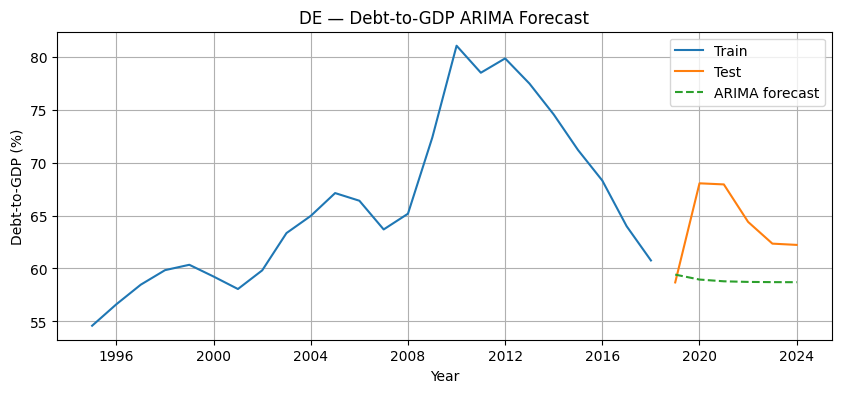

In [100]:

ts = country_ts["Debt_to_GDP"].dropna()

train_size = int(len(ts) * 0.8)
train, test = ts.iloc[:train_size], ts.iloc[train_size:]

# Basic ARIMA baseline (can tune via AIC grid search if needed)
order = (1, 1, 1)
arima = ARIMA(train, order=order).fit()

pred = arima.predict(start=test.index[0], end=test.index[-1])

from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, pred))
print(f"ARIMA{order} RMSE: {rmse:.3f}")

plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test")
plt.plot(pred.index, pred, label="ARIMA forecast", linestyle="--")
plt.title(f"{selected_country} — Debt-to-GDP ARIMA Forecast")
plt.xlabel("Year")
plt.ylabel("Debt-to-GDP (%)")
plt.grid(True)
plt.legend()
plt.show()


### 10.2 VAR model for joint dynamics (Debt-to-GDP, Deficit-to-GDP, GDP Growth)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 20, Feb, 2026
Time:                     11:55:59
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.28742
Nobs:                     19.0000    HQIC:                   1.67692
Log likelihood:          -54.6934    FPE:                    9.63594
AIC:                      1.34883    Det(Omega_mle):         2.01699
--------------------------------------------------------------------
Results for equation Debt_to_GDP
                       coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------
const                     5.188906        11.761104            0.441           0.659
L1.Debt_to_GDP            1.940792         0.299712            6.476           0.000
L1.Deficit_to_GDP        -0.505317    

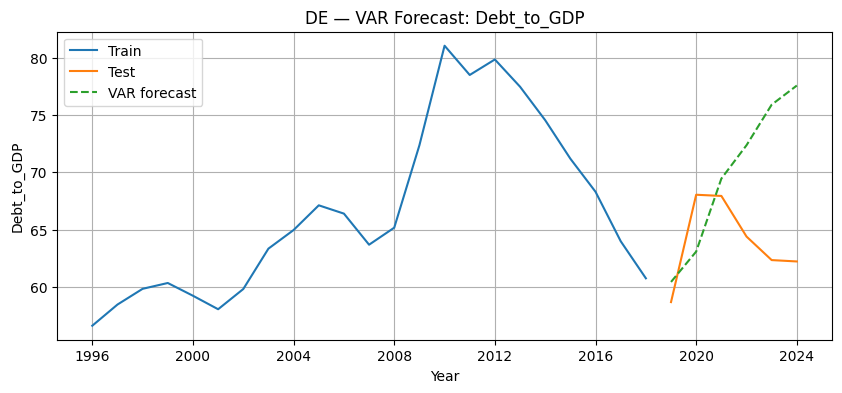

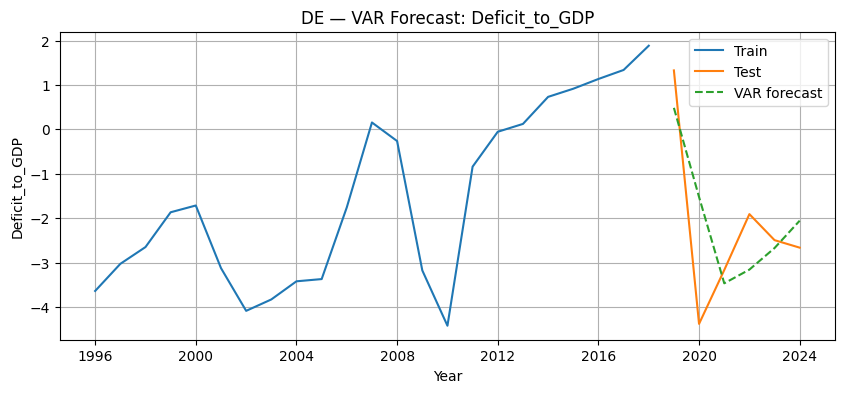

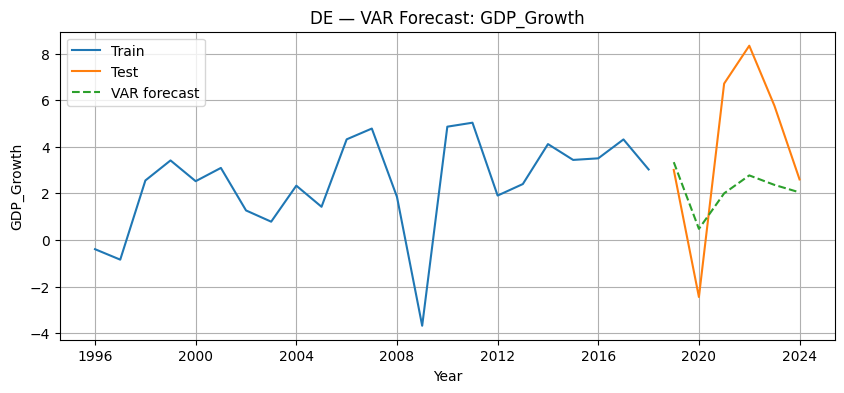

In [101]:

var_df = country_ts[["Debt_to_GDP","Deficit_to_GDP","GDP_Growth"]].dropna()

# Train/test split
train_size = int(len(var_df) * 0.8)
train_v, test_v = var_df.iloc[:train_size], var_df.iloc[train_size:]

model = VAR(train_v)
# Small datasets: keep maxlags low
order_results = model.select_order(maxlags=min(4, len(train_v)//3))
lag = int(order_results.aic) if np.isfinite(order_results.aic) else 1
lag = max(lag, 1)

var_fit = model.fit(lag)
print(var_fit.summary())

# Forecast
fc = var_fit.forecast(train_v.values[-lag:], steps=len(test_v))
fc = pd.DataFrame(fc, index=test_v.index, columns=test_v.columns)

# Evaluate
for col in test_v.columns:
    rmse = np.sqrt(mean_squared_error(test_v[col], fc[col]))
    print(f"{col} RMSE: {rmse:.3f}")

# Plot each variable separately (clean + readable)
for col in test_v.columns:
    plt.figure(figsize=(10,4))
    plt.plot(train_v.index, train_v[col], label="Train")
    plt.plot(test_v.index, test_v[col], label="Test")
    plt.plot(fc.index, fc[col], label="VAR forecast", linestyle="--")
    plt.title(f"{selected_country} — VAR Forecast: {col}")
    plt.xlabel("Year")
    plt.ylabel(col)
    plt.grid(True)
    plt.legend()
    plt.show()


## 11) Storytelling conclusions & policy takeaways

Use this section as your presentation narrative:

1. **What we measured:** debt level, fiscal balance, and debt dynamics.
2. **What we discovered:** clusters of fiscal behavior across Europe.
3. **Stress test lens:** which countries deteriorate most in crises.
4. **Executive score:** a transparent composite risk score.
5. **So what:** policy implications.

### Suggested slide-ready takeaways
- Countries with **high debt + high volatility + weak crisis performance** sit at the top of the risk map.
- Countries with **lower debt** and **stable fiscal balances** cluster together as fiscally stable.
- Crisis sensitivity highlights the importance of **fiscal buffers** and **automatic stabilizers**.
- Risk scores should be interpreted alongside growth: high risk + weak growth is the most concerning quadrant.
